In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import dask

import matplotlib.pyplot as plt
from collections import OrderedDict

from itertools import product
from functools import partial

import obm

/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/glade/work/mclong/miniconda3/envs/dev/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Consider amplitude of thermal and biological forcing

In [2]:
model = obm.onebox.surface_mixed_layer()

In [3]:
ncp_harmonic = partial(obm.forcing_tools.harmonic, mu=0., phase=-0.5, N=365, steps_per_period=365)
sst_harmonic = partial(obm.forcing_tools.harmonic, mu=7., phase=-0.5, N=365, steps_per_period=365)


In [66]:
%%time
do_dask = False

results = []
case = []
thermal_forcing = []
biological_forcing = []

clobber = False

model = {}
state_init = [2033., 308.]
for therm, bio in product(range(0, 5), range(0, 5)):
    casename = f'orcas.gasex-t{therm:03d}-b{bio:03d}'
    case.append(casename)
    thermal_forcing.append(therm)
    biological_forcing.append(bio)
    
    init_file = f'{casename}.npy'
    init_option = 'fsolve'
    
    if os.path.exists(init_file) and not clobber:
        init_option = 'file'
    
    model[casename] = obm.onebox.surface_mixed_layer()
    
    if do_dask:
        model_run = dask.delayed(model[casename].run)
    else:
        model_run = model[casename].run

    forcing_func = lambda therm, bio: model[casename].init_forcing(nday=365., dt=1., 
                                                                   NCP=ncp_harmonic(amp=bio), 
                                                                   TEMP=sst_harmonic(amp=therm))    
        
    out = model_run(time_stop=365., 
                    forcing=forcing_func(therm, bio),
                    init_option=init_option,
                    init_file=init_file,
                    state_init=state_init)
    
    results.append(out)

if do_dask:
    results = dask.compute(*results)
    
case = xr.DataArray(case, dims=('case'), name='case')
ds = xr.concat(results, dim=case)
ds['thermal_forcing'] = xr.DataArray(thermal_forcing, dims=('case'))
ds['biological_forcing'] = xr.DataArray(biological_forcing, dims=('case'))

CPU times: user 2min 28s, sys: 4.38 s, total: 2min 33s
Wall time: 2min 33s


Text(0, 0.5, 'Temperature [°C]')

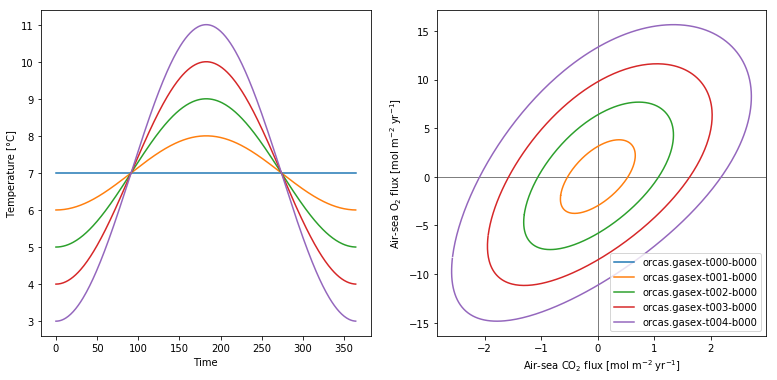

In [72]:
label = lambda da: f"{da.attrs['long_name']} [{da.attrs['units']}]"

xvar = 'stf_CO2'
yvar = 'stf_O2'
caselist = ds.case.loc[ds.biological_forcing==0]


fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 2)
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(-dsc[xvar], -dsc[yvar], label=case.values)
    
ax.axvline(0., color='k', linewidth=0.5, zorder=-10)
ax.axhline(0., color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel(label(ds[xvar]))
ax.set_ylabel(label(ds[yvar]))
plt.legend()

ax = fig.add_subplot(1, 2, 1)    
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(dsc.TEMP, label=case.values)    

ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')
    

Text(0, 0.5, 'NCP [mol/m^2/yr]')

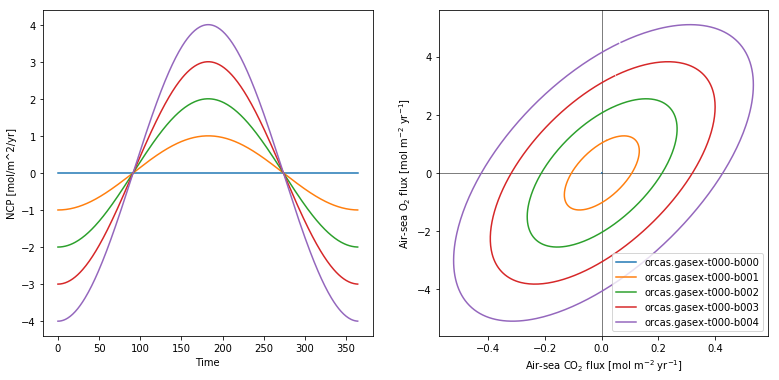

In [70]:
xvar = 'stf_CO2'
yvar = 'stf_O2'

caselist = ds.case.loc[ds.thermal_forcing==0]

fig = plt.figure(figsize=(13, 6))
ax = fig.add_subplot(1, 2, 2)
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(-dsc[xvar], -dsc[yvar], label=case.values)
    
ax.axvline(0., color='k', linewidth=0.5, zorder=-10)
ax.axhline(0., color='k', linewidth=0.5, zorder=-10)

ax.set_xlabel(label(ds[xvar]))
ax.set_ylabel(label(ds[yvar]))
plt.legend()

ax = fig.add_subplot(1, 2, 1)    
for case in caselist:
    dsc = ds.sel(case=case)
    ax.plot(dsc.NCP, label=case.values)    

ax.set_xlabel('Time')
ax.set_ylabel(label(ds.NCP))
    

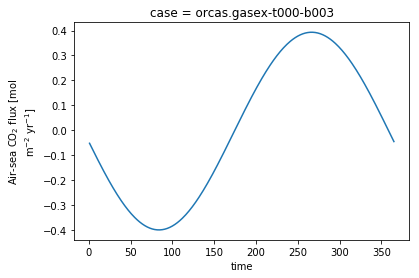

In [22]:
dsc.stf_CO2.plot()

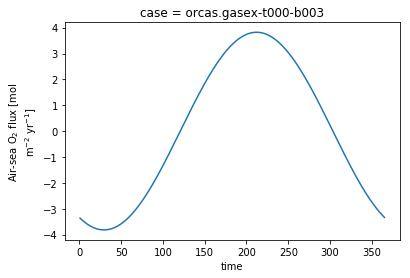

In [29]:
dsc.stf_O2.plot()

In [9]:
out.O2.values[-1]

Delayed('getitem-f58e17686ca116245fb0454e28bfdfc9')

In [10]:
out.NCP.plot()

Delayed('plot-c25b5558-7b90-4dfe-851d-bd361c43192f')